### Concrete Image Classification (CNN)

In [8]:
# Import packages
import pathlib
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, losses, optimizers, applications, models
from tensorflow.keras.utils import image_dataset_from_directory, plot_model
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Load data
FILE_DIR = r'../dataset'
DATA_PATH = pathlib.Path(FILE_DIR)

SEED = 12345
IMG_SIZE = (128, 128)
BATCH_SIZE = 32
train_data = image_dataset_from_directory(DATA_PATH,
                                          validation_split=0.2,
                                          subset='training',
                                          seed=SEED,
                                          shuffle=True,
                                          image_size=IMG_SIZE,
                                          batch_size=BATCH_SIZE
                                          )

validation_data = image_dataset_from_directory(DATA_PATH,
                                               validation_split=0.2,
                                               subset='validation',
                                               seed=SEED,
                                               shuffle=True,
                                               image_size=IMG_SIZE,
                                               batch_size=BATCH_SIZE)

Found 40000 files belonging to 2 classes.
Using 32000 files for training.
Found 40000 files belonging to 2 classes.
Using 8000 files for validation.


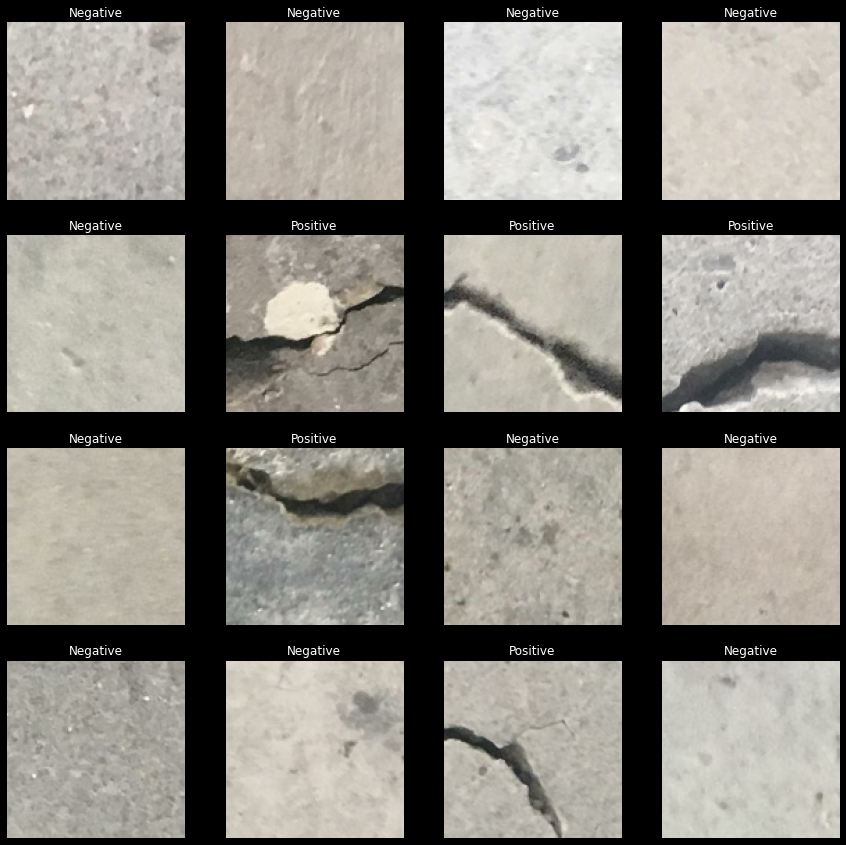

In [3]:
# Split validation into val &test
val_batches = tf.data.experimental.cardinality(validation_data)
test_data = validation_data.take(val_batches//5)
val_data = validation_data.skip(val_batches//5)

# Display examples of data
class_names = train_data.class_names

plt.figure(figsize=(15, 15))
for images, labels in train_data.take(1):
    for i in range(16):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [4]:
# Create Prefetch for train,test,val data
AUTOTUNE = tf.data.AUTOTUNE
pf_train = train_data.prefetch(buffer_size=AUTOTUNE)
pf_test = test_data.prefetch(buffer_size=AUTOTUNE)
pf_val = val_data.prefetch(buffer_size=AUTOTUNE)

In [5]:
# Augmentation layer
data_augmentation = tf.keras.Sequential()
data_augmentation.add(layers.RandomFlip('horizontal_and_vertical'))
data_augmentation.add(layers.RandomRotation(0.2))

In [9]:
# Model creation

class_names = train_data.class_names
nClass = len(class_names)
IMG_SHAPE = IMG_SIZE + (3,)
global_avg = layers.GlobalAveragePooling2D()

inputs = keras.Input(shape=IMG_SHAPE)
h1 = layers.Conv2D(32, (3,3), padding = "same", activation='relu')
h2 = layers.Conv2D(16, (3,3), padding = "same", activation='relu')
h3 = layers.Conv2D(8, (3,3), padding = "same", activation='relu')

c1 = layers.Flatten()
c3 = layers.Dense(32, activation='relu')
c4 = layers.Dense(16, activation='relu')
out_layer = layers.Dense(nClass, activation='softmax')

# Chain the functional API
x = inputs / 255.0 #(preprocess)
x = h1(x) # feature extraction
x = h2(x)
x = h3(x)
x = global_avg(x) # downsizing
x = c1(x) 
x = c3(x)
x = c4(x)
outputs = out_layer(x)

model = keras.Model(inputs=inputs,outputs=outputs)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 128, 128, 3)      0         
 )                                                               
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 16)      4624      
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 128, 8)       1160      
                                                                 
 global_average_pooling2d_1   (None, 8)                0         
 (GlobalAveragePooling2D)                                    

In [10]:
#7. Compile the model
optimizer = optimizers.Adam(learning_rate = 0.001)
loss = losses.SparseCategoricalCrossentropy()

model.compile(optimizer=optimizer,loss=loss,metrics=['accuracy'])

In [11]:
#8. Perform model training
EPOCHS = 5
history = model.fit(pf_train,validation_data=pf_val,epochs=EPOCHS)

Epoch 1/5
1000/1000 [==============================] - 26s 22ms/step - loss: 0.2755 - accuracy: 0.8561 - val_loss: 0.0558 - val_accuracy: 0.9811
Epoch 2/5
1000/1000 [==============================] - 22s 22ms/step - loss: 0.0457 - accuracy: 0.9851 - val_loss: 0.0331 - val_accuracy: 0.9909
Epoch 3/5
1000/1000 [==============================] - 22s 22ms/step - loss: 0.0357 - accuracy: 0.9887 - val_loss: 0.0258 - val_accuracy: 0.9927
Epoch 4/5
1000/1000 [==============================] - 22s 22ms/step - loss: 0.0278 - accuracy: 0.9910 - val_loss: 0.0267 - val_accuracy: 0.9917
Epoch 5/5
1000/1000 [==============================] - 22s 22ms/step - loss: 0.0301 - accuracy: 0.9906 - val_loss: 0.0208 - val_accuracy: 0.9939


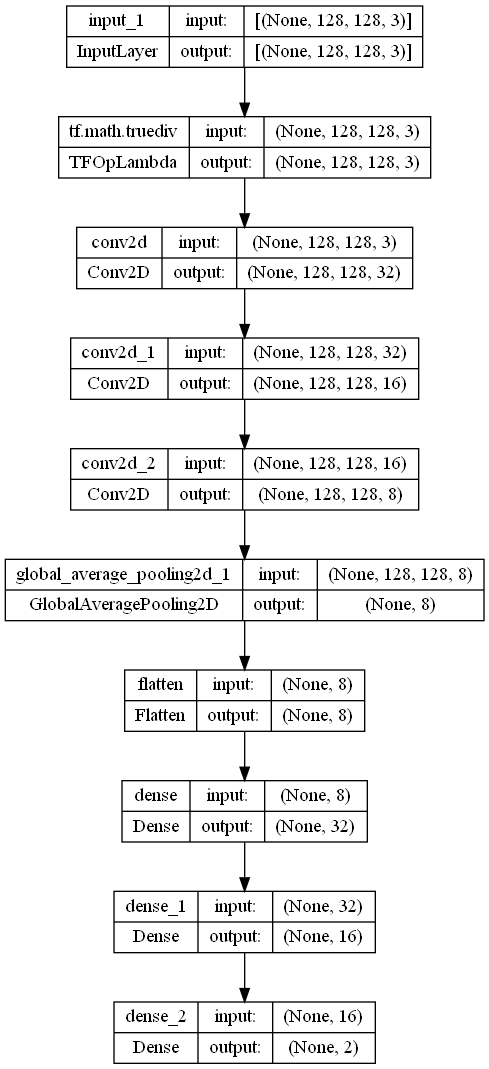

In [12]:
img_file = '../public/model_plot_cnn.png'
plot_model(model, to_file=img_file, show_shapes=True)

In [13]:
# Model evaluation
test_loss, test_accuracy = model.evaluate(pf_test)
print("====================MODEL EVALUATION======================")
print(f"Test Loss : {test_loss}")
print(f"Test Accuracy : {test_accuracy}")

50/50 [==============================] - 1s 11ms/step - loss: 0.0176 - accuracy: 0.9950
====================MODEL EVALUATION======================
Test Loss : 0.017649857327342033
Test Accuracy : 0.9950000047683716


In [14]:
# Make predictions
image_batch, label_batch = pf_test.as_numpy_iterator().next()
predicted_labels = np.argmax(model.predict(image_batch), axis=1)

1/1 [==============================] - 0s 86ms/step


In [15]:
# Compare label against predictions
label_vs_prediction = np.transpose(np.vstack((label_batch, predicted_labels)))

In [16]:
print(label_vs_prediction)

[[1 1]
 [1 1]
 [0 0]
 [1 1]
 [1 1]
 [0 0]
 [0 0]
 [1 1]
 [0 0]
 [1 1]
 [1 1]
 [0 0]
 [1 1]
 [0 0]
 [1 1]
 [0 0]
 [0 0]
 [1 1]
 [0 0]
 [1 1]
 [0 0]
 [0 0]
 [1 1]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [1 1]
 [1 1]
 [1 1]
 [1 1]
 [1 1]]


1/1 [==============================] - 0s 16ms/step


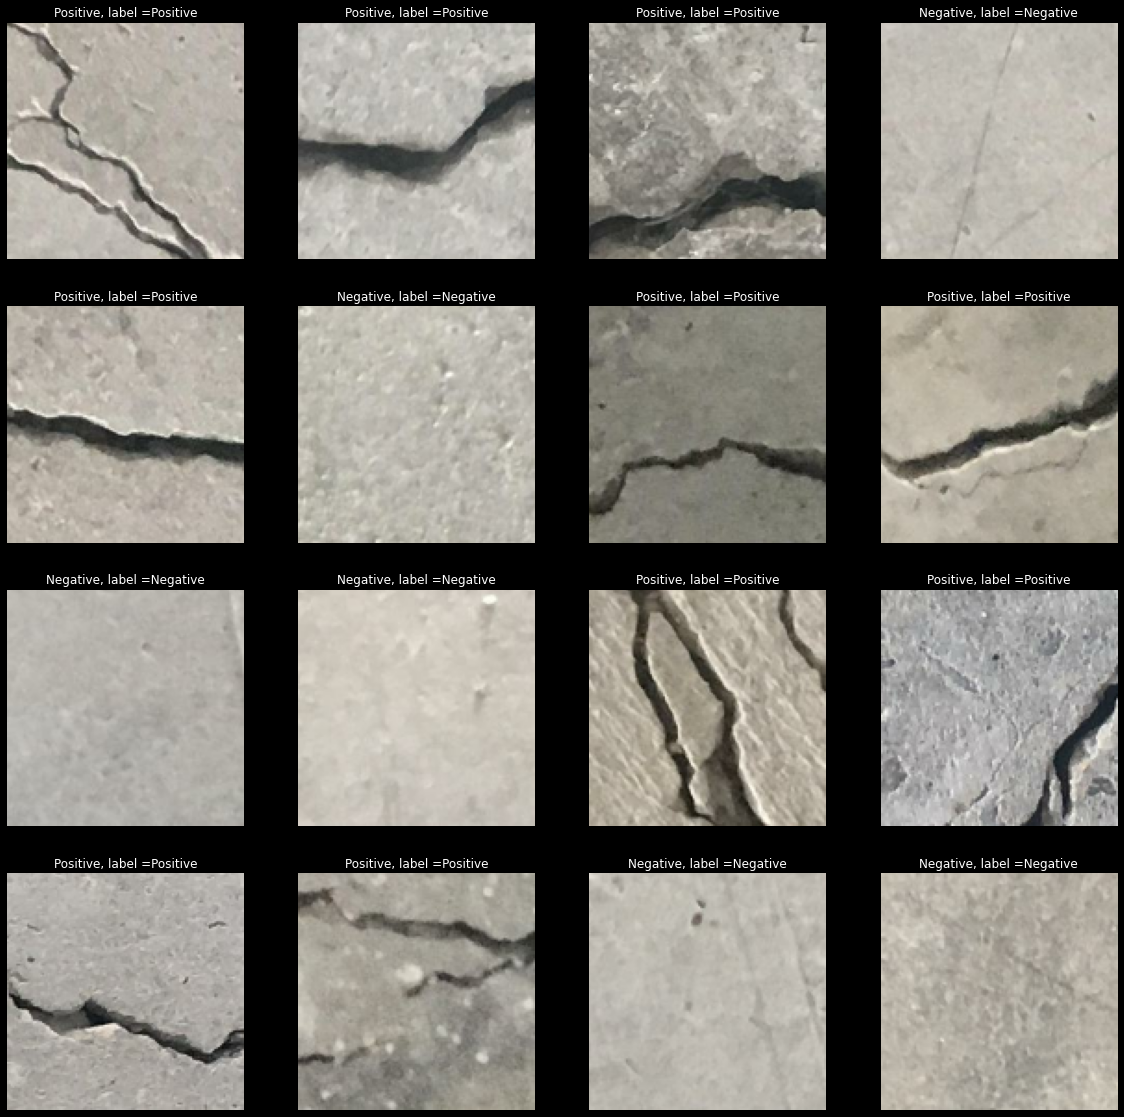

In [17]:
# Display the images with predictions and label
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 20))
class_names = train_data.class_names
for images, labels in test_data.take(1):
  for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(str(class_names[np.argmax(model.predict(images),axis=1)[i]])+", label ="+str(class_names[labels[i]]))
    plt.axis("off")

 As observed, we managed to get 99.5% accuracy in classifiying the concrete cracks using a simple CNN model.